In [1]:
import pandas as pd
from collections import Counter
from itertools import islice
from sklearn.neural_network import MLPRegressor
from time import time
import matplotlib.pyplot as plt

import gensim.parsing.preprocessing as gsp
from gensim.parsing.preprocessing import preprocess_string

import Drain
from Doc2Vec import Doc2VecTransformer
import utils

In [2]:
key_list = ["Level", "Content", "EventTemplate"]
filters = [
           gsp.strip_tags, 
           gsp.strip_punctuation,
           gsp.strip_multiple_whitespaces,
           gsp.strip_numeric,
           gsp.remove_stopwords, 
          #  gsp.strip_short, 
           gsp.stem_text
          ]

In [3]:
input_dir  = 'logs'
output_dir = 'result/'
log_file   = 'log.trc'
log_format = '<Date> <Time> <time_zone> <Level> <Component> <log_tag> <Content>'

pre_regex = [r'\]',
             r'\[']
regex      = [r'/[^\/]+',
              r'\d+',
              r'_[^\/]+_']
st         = 0.3
depth      = 4

In [4]:
parser = Drain.LogParser(log_format, indir=input_dir, outdir=output_dir,  depth=depth, st=st, rex=regex, pre_rex = pre_regex)
df = parser.parse(log_file)
df = df[key_list]
df["EventTemplate"] = df["EventTemplate"].map(lambda x: utils.clean_text(x, filters))

Parsing file: logs/tfa_main.trc
Processed 27.5% of log lines.
Processed 55.0% of log lines.
Processed 82.6% of log lines.
Processed 100.0% of log lines.
Parsing done. [Time taken: 0:00:00.449160]


<ipython-input-4-8e39dc9ba97a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["EventTemplate"] = df["EventTemplate"].map(lambda x: utils.clean_text(x, filters))


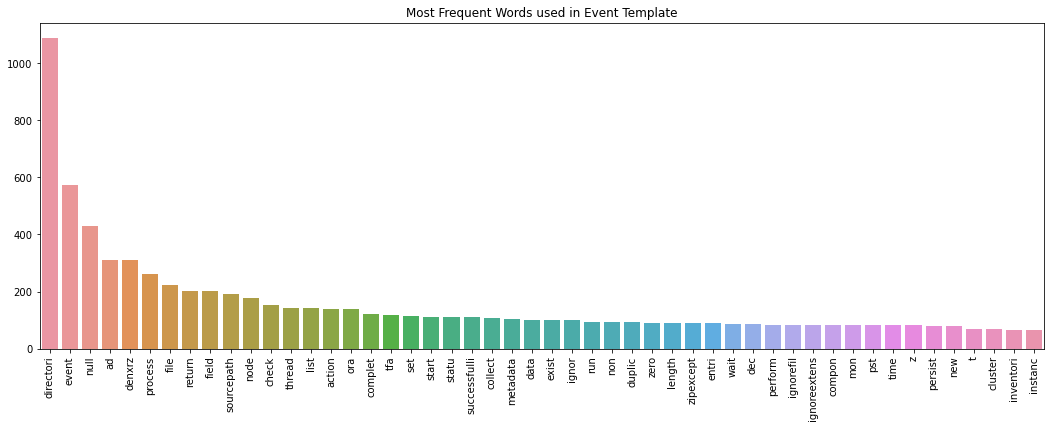

In [5]:
aggregate_counter = Counter()
for row_index,row in df.iterrows():
    c = Counter(row["EventTemplate"].split())
    aggregate_counter += c

common_words = [word[0] for word in aggregate_counter.most_common(50)]
common_words_counts = [word[1] for word in aggregate_counter.most_common(50)]

utils.barplot(words=common_words, words_counts=common_words_counts, title='Most Frequent Words used in Event Template')

In [ ]:
all_word_counts = sorted(aggregate_counter.items(), key=utils.key_word_counter)
uncommon_words = [word[0] for word in islice(all_word_counts, 50)]
uncommon_word_counts = [word[1] for word in islice(all_word_counts, 50)]

utils.barplot(words=uncommon_words, words_counts=uncommon_word_counts, title='Least Frequent Words used in Event Template')

In [6]:
doc2vec_tr = Doc2VecTransformer(vector_size=300, epochs=20)
doc2vec_tr.fit(df)
doc2vec_vectors = doc2vec_tr.transform(df)

100%|██████████| 3634/3634 [00:00<00:00, 2947041.91it/s]


In [7]:
auto_encoder = MLPRegressor(hidden_layer_sizes=(
                                                 600,
                                                 150,
                                                 600,
                                               ), max_iter = 100)
auto_encoder.fit(doc2vec_vectors, doc2vec_vectors)

MLPRegressor(hidden_layer_sizes=(600, 150, 600), max_iter=100)

In [8]:
predicted_vectors = auto_encoder.predict(doc2vec_vectors)

print("Accuracy: ", auto_encoder.score(predicted_vectors, doc2vec_vectors))

Accuracy:  0.9933305279255478


In [9]:
sorted_cosine_similarities = utils.get_computed_similarities(vectors=doc2vec_vectors, predicted_vectors=predicted_vectors, df=df)
utils.display_top_n(sorted_cosine_similarities=sorted_cosine_similarities, df=df, n=200)